Initial exploratory data analysis for PH predictor module.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Load raw data and show columns.

In [2]:
raw_data = pd.read_csv('../data/raw/data_raw_2022-11-06.csv')
raw_data.columns

Index(['Unnamed: 0', 'matthews', 'percent_solvent', 'rcsb_id', 'method', 'pH',
       'conditions', 'temp', 'resolution', 'organism', 'sequence'],
      dtype='object')

Select columns relevant for pH prediction, check info to see if general size and number of NaNs.

In [3]:
proc_data = raw_data[['rcsb_id', 'pH', 'sequence']]
proc_data = proc_data.set_index('rcsb_id')
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123352 entries, 101M to 9XIM
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pH        95672 non-null   float64
 1   sequence  122948 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.8+ MB


Drop NaNs, chenge sequence dtype to string. Calculate seqence length. Visualize pH and length distribution.

                 pH       len_seq
count  95672.000000  95672.000000
mean       6.776959    299.193933
std        1.303877    171.265304
min        0.000000      4.000000
5%         4.500000     99.000000
50%        7.000000    274.000000
95%        8.500000    595.000000
max       12.000000   4128.000000


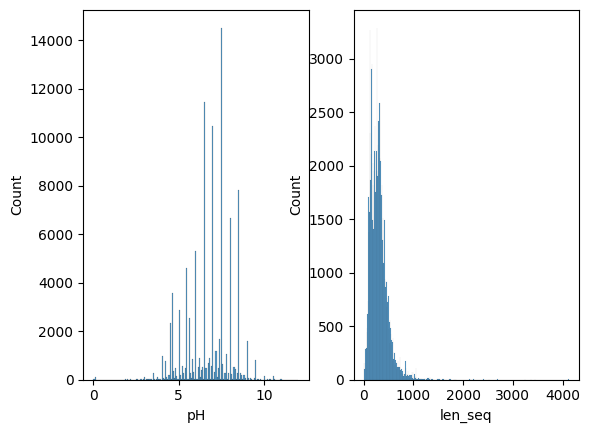

In [4]:
proc_data = proc_data.dropna()
proc_data['sequence'] = proc_data['sequence'].astype('string')
proc_data['len_seq'] = proc_data['sequence'].map(len)
print(proc_data.describe(percentiles=[0.05,0.95]))
fig, axes = plt.subplots(1,2)
sns.histplot(data=proc_data, x='pH', ax=axes[0])
sns.histplot(data=proc_data, x='len_seq',ax=axes[1])
plt.show()

Drop pH lower than 3 and higher than 10 (based on available screens and expertise). Drop sequences shorter than 100 and longer than 600 - approx. based on 0.05 and 0.95 percentiles.

                 pH       len_seq
count  85682.000000  85682.000000
mean       6.778237    285.284190
std        1.266922    117.697687
min        3.000000    100.000000
5%         4.500000    123.000000
50%        7.000000    275.000000
95%        8.500000    505.000000
max       10.000000    600.000000


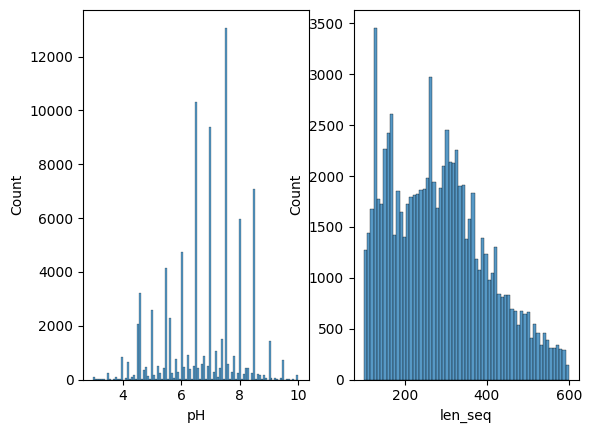

In [5]:
proc_data = proc_data[(proc_data['pH'] >= 3) & (proc_data['pH'] <= 10)]
proc_data = proc_data[(proc_data['len_seq'] >= 100) & (proc_data['len_seq'] <= 600)]
print(proc_data.describe(percentiles=[0.05,0.95]))
fig, axes = plt.subplots(1,2)
sns.histplot(data=proc_data, x='pH', ax=axes[0])
sns.histplot(data=proc_data, x='len_seq',ax=axes[1])
plt.show()

Check for non-standard AA in sequences.

In [6]:
one_big_string =''.join(proc_data['sequence'])
char_counts = {c:one_big_string.count(c) for c in set(one_big_string)}
for key, value in sorted(char_counts.items()):
    print(f'{key} : {value}')

A : 1990038
B : 15
C : 333512
D : 1414470
E : 1587786
F : 982499
G : 1848001
H : 719676
I : 1359615
K : 1402189
L : 2236773
M : 584511
N : 1011101
O : 4
P : 1141606
Q : 890442
R : 1215459
S : 1504701
T : 1333165
U : 18
V : 1705362
W : 336156
X : 4752
Y : 841845
Z : 24


Figuring out one hot encoding of amino acid sequences.

In [7]:
aa_names = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','#']
encoder = OneHotEncoder(categories = [aa_names], sparse = False)
def encode_aa(sequence:str, max_len:int):
    
    sequence_padded = sequence.ljust(max_len, '#')
    seq_array = np.array(list(sequence_padded)).reshape(-1,1)
        
    return encoder.fit_transform(seq_array)

encoded_example = encode_aa(proc_data['sequence'][14241], 600)

encoded_example


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])